In [ ]:
#installation of scikit uplift library
!pip install scikit-uplift xgboost==1.0.2 category_encoders==2.1.0 -U


     |████████████████████████████████| 109.8MB 47kB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


###**Importing support libraries**

In [ ]:
import io
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklift.models import TwoModels
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from tabulate import tabulate 
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

###**Support functions and class**

###**Data loading**

In [ ]:
#uploading files from local to colab
from google.colab import files
uploaded = files.upload()

Saving bank-full.csv to bank-full.csv


In [ ]:
#Loading data as pandas dataframe
data_bank = pd.read_csv(io.StringIO(uploaded['bank-full.csv'].decode('utf-8')),sep=';')

In [ ]:
#Direct uploading if not using colab
#data_bank = pd.read_csv("data/bank-full.csv",sep=';')

In [ ]:
#Dropping duration column
data_bank = data_bank.drop('duration',axis=1)
# Creating treatment col according to the contact ,ie control=0 and treatment=1
treatment = []*len(data_bank)
treatment_array = []*len(data_bank)
for x in data_bank['contact']:
  if x=="unknown":
    treatment.append(0)
    treatment_array.append('control')
  else:
    treatment.append(1)
    treatment_array.append('treatment')
data_bank['treatment']=treatment
print(data_bank)

# Encoding using lable encoder
categorical = ['job','marital','education','housing','loan','contact','month','poutcome','default','month','balance', 'y']
for c in categorical:
    data_bank[c] = LabelEncoder().fit_transform(data_bank[c])
    data_bank[c] = data_bank[c]


       age           job   marital  ... poutcome    y  treatment
0       58    management   married  ...  unknown   no          0
1       44    technician    single  ...  unknown   no          0
2       33  entrepreneur   married  ...  unknown   no          0
3       47   blue-collar   married  ...  unknown   no          0
4       33       unknown    single  ...  unknown   no          0
...    ...           ...       ...  ...      ...  ...        ...
45206   51    technician   married  ...  unknown  yes          1
45207   71       retired  divorced  ...  unknown  yes          1
45208   72       retired   married  ...  success  yes          1
45209   57   blue-collar   married  ...  unknown   no          1
45210   37  entrepreneur   married  ...    other   no          1

[45211 rows x 17 columns]


###**Data Analysis**

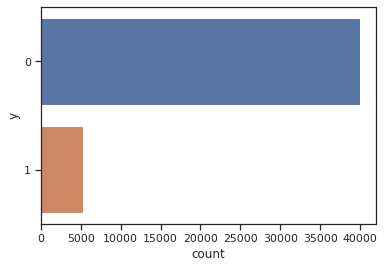

In [ ]:
# Outcome review 
sns.set(style="ticks", color_codes=True)
sns.countplot(y='y', data=data_bank)

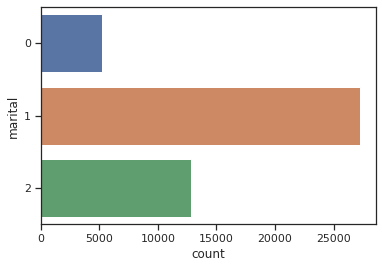

In [ ]:
# marital status count
sns.countplot(y='marital', data=data_bank)

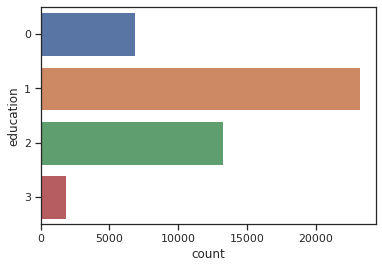

In [ ]:
# education count
sns.countplot(y='education', data=data_bank)

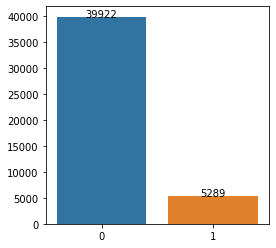

In [ ]:
# Treatment review 
labels=data_bank['y'].value_counts().index
values=data_bank['y'].value_counts().values
plt.figure(figsize = (4, 4))
ax = sns.barplot(x=labels, y=values)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, values[i],ha="center")

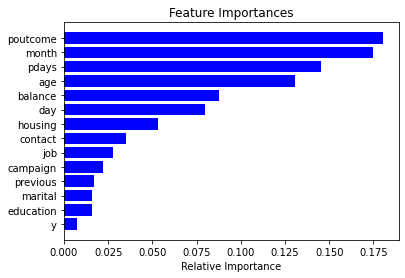

In [ ]:
# Finding important features 

model = RandomForestRegressor(random_state=1, max_depth=10)

model.fit(X,y)
features = data_bank.columns

importances = model.feature_importances_

indices = np.argsort(importances)[-14:]  # top 15 features


plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#selecting imortant 10 features according to graph above
features_columns_r=['job','education', 'age', 'campaign','month', 'day', 'pdays', 'previous', 'poutcome', 'balance','treatment','y']

features_columns_response = data_bank[features_columns_r]

array = features_columns_response.values

# separate array into input and output components
X_r = data_bank.drop(['y'],axis=1)
y_r = data_bank['y']



### **Data Preprocessing**

####Response modeling

In [ ]:
#Seperatng data into train and test
Xyt_train, Xyt_test = train_test_split(data_bank, test_size=0.3, random_state=7)

X_train_response = Xyt_train.drop(['y', 'treatment'], axis=1)
y_train_response = Xyt_train['y']
treatment_train_response = Xyt_train['treatment']

X_test_response = Xyt_test.drop(['y', 'treatment'], axis=1)
y_test_response = Xyt_test['y']
treatment_test_response = Xyt_test['treatment']

###**Model fitting**

In [ ]:
#Helper function for True positive,False positive,True negative,False negative calculation using confusion matrix
def perf_measure(y_true, y_pred):
  CM = confusion_matrix(y_true, y_pred)
  TN = CM[0][0]
  FN = CM[1][0]
  TP = CM[1][1]
  FP = CM[0][1]
  return(TP, FP, TN, FN)

In [ ]:
#Defining the models used
models = [('Random Forest', RandomForestClassifier(n_estimators=100)),
          ('XGBoost',xgb.XGBClassifier())]

#Defining col for result dataframe
col = ['Classifiers','Accuracy','AUC score','True positive','False positive','True negative','False negative']
 
auc_score = 0
model_results =[]

#Training model and evaluating based on accuracy and recording it in dataframe
for name,model in models:
  result = []
  model.fit(X_train_response,y_train_response)
  y_pred = model.predict(X_test_response)
  y_score = model.predict_proba(X_test_response)[:,1]
  accuracy = metrics.accuracy_score(y_test_response, y_pred)
  TP, FP, TN, FN = perf_measure(y_test_response, y_pred)
  auc_score = roc_auc_score(y_test_response, y_score)
  result = [name,accuracy,auc_score,TP, FP, TN, FN]
  model_results.append(result)
 
model_results = np.array(model_results)
df_results = pd.DataFrame(model_results,columns=col)
df_results[['Accuracy','AUC score','True positive','False positive','True negative','False negative']] = df_results[['Accuracy','AUC score','True positive','False positive','True negative','False negative']].apply(pd.to_numeric)

print(tabulate(df_results, headers = col, tablefmt = 'psql')) 


+----+---------------+------------+-------------+-----------------+------------------+-----------------+------------------+
|    | Classifiers   |   Accuracy |   AUC score |   True positive |   False positive |   True negative |   False negative |
|----+---------------+------------+-------------+-----------------+------------------+-----------------+------------------|
|  0 | Random Forest |   0.892067 |    0.782682 |             289 |              219 |           11811 |             1245 |
|  1 | XGBoost       |   0.892657 |    0.788143 |             365 |              287 |           11743 |             1169 |
+----+---------------+------------+-------------+-----------------+------------------+-----------------+------------------+


### **Evaluation**

In [ ]:
#Helper functions for plotting roc and confusion matrix

def plot_roc(y_true, y_score):
  skplt.metrics.plot_roc_curve(y_true, y_score)
  plt.show() 
def plot_confusion_matrix(y_test,y_pred,name):
  confusion_matrix = pd.crosstab(y_test,y_pred, rownames=['Actual'], colnames=['Predicted'])
  sns.heatmap(confusion_matrix, annot=True)
  #print(df_confusion)
  plt.title("Confusion Matrix"+''+name)

Random Forest
AUC: 0.78


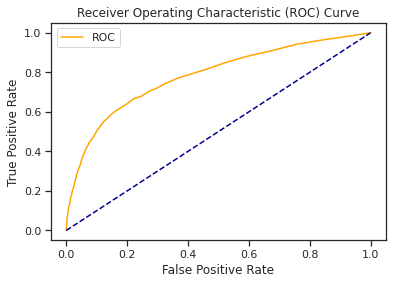

XGBoost
AUC: 0.79


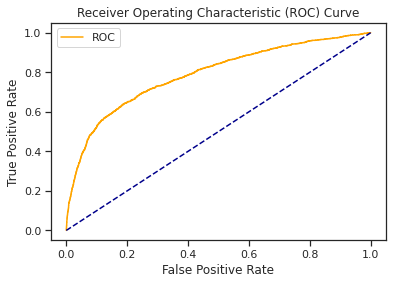

In [ ]:
#ROC curve
for name,model in models:
  model.fit(X_train_response,y_train_response)
  y_pred = model.predict(X_test_response)
  probs = model.predict_proba(X_test_response)
  probs = probs[:, 1]
  print(name)
  plot_roc(y_test_response,probs)

  


In [ ]:
# plots confusion matrix
for name,model in models:
  plt.figure()
  model.fit(X_train_response,y_train_response)
  y_pred = model.predict(X_test_response)
  plot_confusion_matrix(y_test_response,y_pred,name)
  
  plt.show()

#### **Qini**

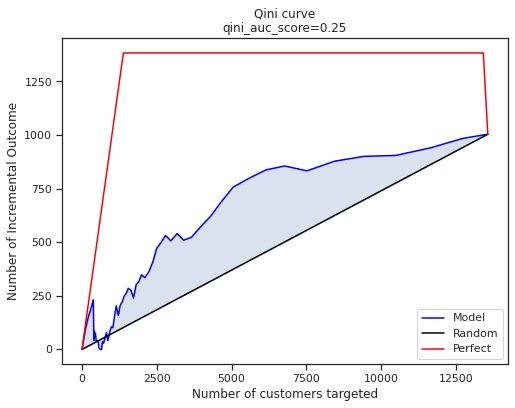

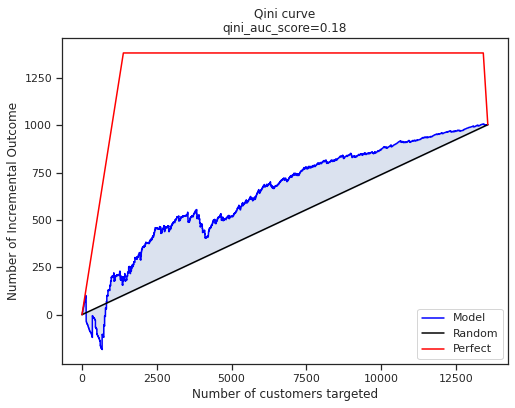

In [ ]:
# plotting qini curve for the models

from sklift.viz import plot_qini_curve

for name,model in models:
  model.fit(X_train_response,y_train_response)
  y_pred = model.predict(X_test_response)
  prob_score = model.predict_proba(X_test_response)[:,1]
  plot_qini_curve(y_true=y_test_response, uplift=prob_score, treatment=treatment_test_response)
  #plt.title(name)
  x = [2500, 5000, 7500, 10000, 12500, 15000]
  y = [250, 500, 750, 1000, 1250, 1500]
  #plt.title(name)
  plt.xticks(np.arange(0, 15000, 2500))
  plt.yticks(np.arange(0, 1500, 250))
  plt.xlabel('Number of customers targeted')
  plt.ylabel('Number of Incremental Outcome')
